# Ensemble Kalman Filter Workflow

1. From the first observation $I_0$ and the second observation $I_1$, calculate $dt$ (time to run the simulation for)
2. From the weather station data, obtain windspeed **(ws)** and wind direction **(wd)** at the time of $I_0$, then create an ensemble of **ws** and **wd**, based on a normal distribution
3. Run FARSITE from $I_0$ with the ensemble pairs (**ws, wd**) for dt time. This will create a matrix, $X_t$, of size $(2d+2)\times N$, where $d$ is the number of vertices, and $+2$ is the additional **ws** and **wd** values.
4. From the second observation $I_1$, deviate each vertex randomly from a normal distribution with a radius and std, and obtain M new geometries. Note that obtainin new geometries may require crossing out sections from the geometry to make it valid. Check how this process changes the radius and sigma. This will create a new matrix $Y$ of size $2d \times M$
5. Obtain the errors $E_{X_t}$ and $E_Y$ using the mean $X_t$ column $\bar x_t$ and the observation from $I_0 \rightarrow y$
$$ E_{X_t} = (x_t^0 - \bar x_t , x_t^1 - \bar x_t , \cdots)$$
$$ E_Y = (y^0 - y, y_1 - y, \cdots)$$
6. Calculate the covariance matrices $P_{XY}$ and $P_Y$ of sizes 
$$ P_{XY} = \frac{1}{2d-1}E_XE_Y^T$$
$$ P_Y = \frac{1}{2d-1}E_YE_Y^T$$
7. Calculate the Kalman filter $K = P_{XY}P_Y^{-1}$. Note that while calculating the inverse of the covariance, you can use the psesudoinverse function fin numpy as np.linalg.pinv(...)
8. Calculate the updated state matrix $X'$ using the Kalman filter:
$$X' = X + K(Y - CX),$$
where $C$ is the matrix to remap $2d+2$ dimensions to $2d$, simply generated with an identity matrix + 2 zero columns for each **ws** and **wd**

## Dependencies:

In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

import datetime

## Default Values

In [2]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [3]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = SELECTED_FIRE_DEFAULT
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


1. From the first observation $I_0$ and the second observation $I_1$, calculate $dt$ (time to run the simulation for)

-- referenceidx_lst[0] is $I_0$, and referenceidx_lst[1] is $I_1$

In [4]:
referenceidx_lst = [usr.db.gdfignition.index[0]] + usr.db.gdfignition[usr.db.gdfignition['objectid'] == '21231_RefTruth'].index.tolist()

### Plot all the reference geometries

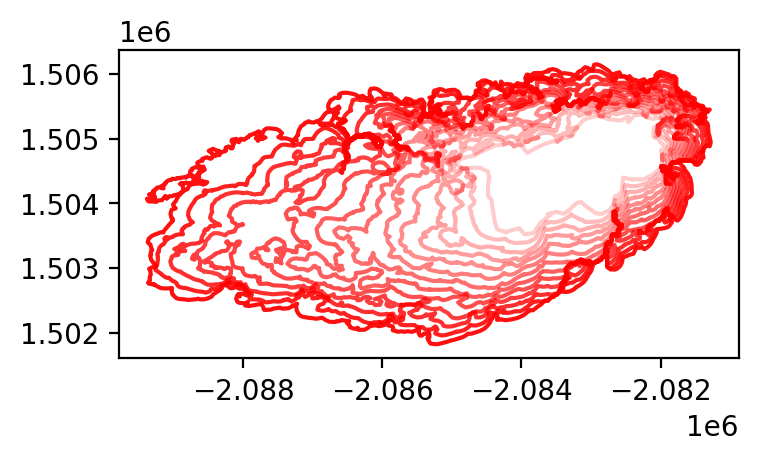

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

for i, referenceidx in enumerate(referenceidx_lst):
    x,y = usr.db.gdfignition.loc[referenceidx,'geometry'].exterior.coords.xy
    ax.plot(x, y, color=(1,0,0,1/5+i/5*4/len(referenceidx_lst)))

2. From the weather station data, obtain windspeed **(ws)** and wind direction **(wd)** at the time of $I_0$, then create an ensemble of **ws** and **wd**, based on a normal distribution

--- Ground truth data was run with 30-min time intervals, with wd=90 and ws=10. Here, we deviate the first measurement referenceidx_lst[0] and run with the same wind parameters. Then, we will create an ensemble on wd and ws to apply EnKF for the FARSITE outputs. *Effectively, we are transforming the deviation on the ignition to the wind parameters, and use EnKF to correct the deviation* 


In [6]:
class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)

def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]

In [9]:
def calculate(igniteidx, compareidx, usr, label, windspeed = 10, winddirection = 90):
    lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
    barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

    # Generate df for the next reference ignition only to get the datetime
    filetype = 'Ignition'
    # objectid = str(usr.db.gdfignition.loc[igniteidx, 'objectid']) + '_simRef'
    filepath = f'/home/jovyan/farsite/inputs/maria_ignite/maria_{compareidx}'
    comparedatetime = usr.db.gdfignition.loc[igniteidx, 'datetime'] + datetime.timedelta(minutes=30)
    description = SELECTED_FIRE_DEFAULT

    gdfcompare = gpd.GeoDataFrame(index=[compareidx], data = {'filetype': filetype,
                                          'objectid': label,
                                          'filepath': filepath,
                                          'datetime': comparedatetime,
                                          'description': description,
                                          'geometry': None})

    usr.db.gdfignition = pd.concat([usr.db.gdfignition, gdfcompare])

    inputData = {'description': description,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

    # Collect the simulated geometry
    gdfsim = usr.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)

    # Update the ignition table with the simulated info
    usr.db.gdfignition.loc[compareidx, 'filepath'] = usr.db.gdfsimulation.iloc[-1]['filepath']
    usr.db.gdfignition.loc[compareidx, 'geometry'] = gdfsim_geom
    
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                 crs='EPSG:5070').to_file(gdfsim['filepath'])

In [8]:
igniteidx_lst = [usr.db.gdfignition[usr.db.gdfignition['objectid'] == '21231_Deviate'].index[0]] + [uuid.uuid4().hex for i in range(12)]

In [11]:
for i in range(len(igniteidx_lst[:-1])):
    print('\n---------------------------------')
    print(f'Calculating {i}/{len(igniteidx_lst)}')
    calculate(igniteidx_lst[i], igniteidx_lst[i+1], usr, label='21231_Deviate', windspeed = 10, winddirection = 90)


---------------------------------
Calculating 0/13
{'description': 'Maria2019', 'igniteidx': 'f72ef3330247465e88cdb8a27e2a2df6', 'compareidx': '5d2dd067d29d41b6a47893976a37474e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230514/Run_01500/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Mariaf72ef3330247465e88cdb8a27e2a2df6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230514/Run_01500/out

----------------------

Calculate the error between the reference truth and the deviation

In [12]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=100)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices

In [13]:
# Plotting matrices

def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)


In [14]:
def validate_geoms_matrix(X, aligned_geom):
    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        xx,yy = geom.exterior.xy
        xx = list(xx)
        yy = list(yy)

        geom = np.array(interpolate_perimeter(list(zip(xx, yy)), len(x)))
        geom = align_vertices([aligned_geom, geom])[1]

        X[:,i] = geom.flatten()

    return X

def update_EnKF(Xt, Y, aligned_geom):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)

    max_Py = abs(Py).max()
    max_Pxy = abs(Pxy).max()
    Py /= max_Py
    Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    # K = np.matmul(Pxy, Py_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

In [15]:
gdfreference = usr.db.gdfignition.loc[referenceidx_lst]   # Reference true perimeters
gdfdeviate = usr.db.gdfignition.loc[igniteidx_lst]     # Same calculation from a deviated geometry

errors_rms = []
errors_areadiff = []

for (geom1, geom2) in zip(gdfreference['geometry'].tolist(), gdfdeviate['geometry'].tolist()):
    errors_rms.append(calculate_rms(geom1, geom2))
    errors_areadiff.append(calculate_area_diff(geom1, geom2))

Text(0.5, 1.0, 'Errors without Kalman Filters')

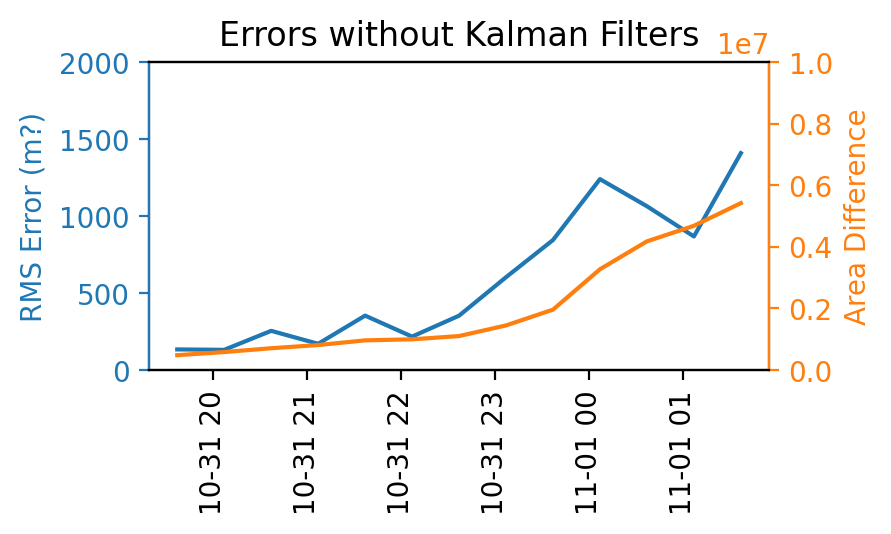

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
ax2 = ax.twinx()

ax.plot(gdfreference['datetime'], errors_rms, color='tab:blue')
ax.set_ylim(0,2000)
ax.set_ylabel('RMS Error (m?)', color='tab:blue')
ax.tick_params(axis='y', colors='tab:blue')
ax2.spines['left'].set_color('tab:blue')

ax2.plot(gdfreference['datetime'], errors_areadiff, color='tab:orange')
ax2.set_ylim(0,1e7)
ax2.set_ylabel('Area Difference', color='tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.spines['right'].set_color('tab:orange')
# ax2.yaxis.set_ticklabels(ax2.yaxis.get_ticklabels(), color='tab:orange')


ax.xaxis.set_tick_params(rotation=90)

ax.set_title('Errors without Kalman Filters')


In [17]:
ws = 10
wd = 90
nsamples = 1000
vertex_count = 100

# Generate 250 samples of (ws, wd)
wsar = np.random.normal(ws, np.sqrt(ws), nsamples)
wdar = np.random.normal(wd, 15, nsamples)

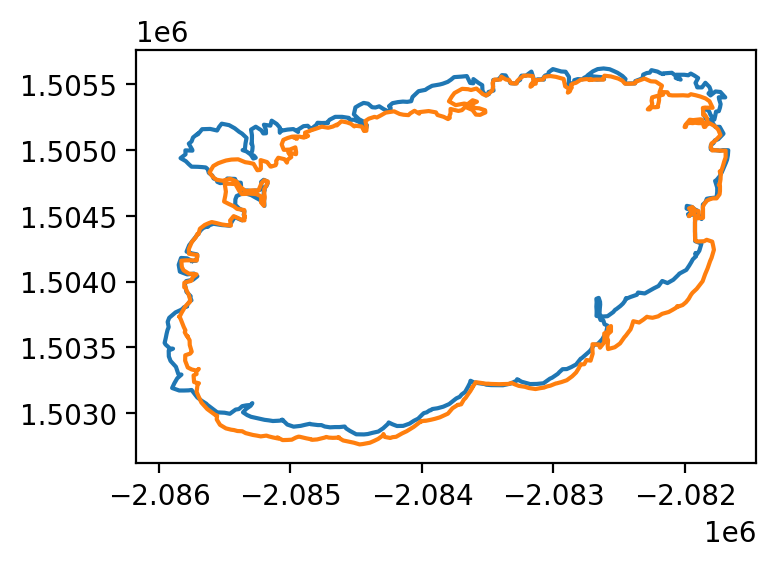

In [18]:
fig, ax= plt.subplots(1,1, figsize=(4,4), dpi=200)
iloc = 5

x,y = gdfreference.iloc[iloc]['geometry'].exterior.xy
ax.plot(x,y)

x,y = gdfdeviate.iloc[iloc]['geometry'].exterior.xy
ax.plot(x,y)

ax.set_aspect('equal')

In [20]:
compareidx = {}
# Run for the first ensemble 0->1

igniteidx = igniteidx_lst[0]
compareidx[igniteidx] = []
usr_test = futils.User(fp)
for wsflt, wdflt in zip(wsar, wdar):
    wsint = round(wsflt)
    wdint = np.fmod(round(wdflt)+360, 360)
    
    print(f'\nCalculating for wd={wdint}, ws={wsint}')
    
    # calculate compareidx for the updated
    compareidx[igniteidx].append(uuid.uuid4().hex)
    calculate(igniteidx, compareidx[igniteidx][-1], usr_test, label='21231_Deviated_1', windspeed = wsint, winddirection = wdint)    

Database interaction not yet implemented. Use pickle file for dataframes instead!

Calculating for wd=110, ws=6
{'description': 'Maria2019', 'igniteidx': 'f72ef3330247465e88cdb8a27e2a2df6', 'compareidx': 'ce6fd6c973644172b5bbb22fc4c9cf02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 6, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 48).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230514/Run_01512/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Mariaf72ef3330247465e88cdb8a27e2a2df6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /hom

In [21]:
def fill_zeros(A, nonzerolen, nsamples):
    
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A

def create_ensemble_matrix(gdf, nsamples, vertex_count=20, aligned_geom=None, observed=False):

    geoms = gdf['geometry'].tolist()
    
    if not observed:
        wdlst = gdf['winddirection'].tolist()
        wslst = gdf['windspeed'].tolist()
    
    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2 + 2*(not observed), nsamples))  # Two additional for each wd ans ws
    for i, vertices in enumerate(aligned_vertices):
        if observed:
            X[:,i] = vertices.flatten()
        else:
            X[:-2,i] = vertices.flatten()
        
        if not observed:
            X[-2,i] = wdlst[i]
            X[-1,i] = wslst[i]
        
    X = fill_zeros(X, len(geoms), nsamples)
    
    return X, aligned_geom, vertex_count

In [22]:
Xt, aligned_geom, vertex_count = create_ensemble_matrix(usr_test.db.gdfsimulation, nsamples, vertex_count=100)

In [24]:
Xt

array([[-2.08499100e+06, -2.08502600e+06, -2.08523300e+06, ...,
        -2.08505900e+06, -2.08495017e+06, -2.08507250e+06],
       [ 1.50462700e+06,  1.50465700e+06,  1.50453100e+06, ...,
         1.50445700e+06,  1.50453430e+06,  1.50443490e+06],
       [-2.08490378e+06, -2.08492698e+06, -2.08523300e+06, ...,
        -2.08499990e+06, -2.08497500e+06, -2.08500796e+06],
       ...,
       [ 1.50462700e+06,  1.50465700e+06,  1.50445114e+06, ...,
         1.50445700e+06,  1.50447948e+06,  1.50439194e+06],
       [ 1.10000000e+02,  1.02000000e+02,  7.60000000e+01, ...,
         8.70000000e+01,  7.10000000e+01,  7.30000000e+01],
       [ 6.00000000e+00,  1.00000000e+01,  1.60000000e+01, ...,
         1.30000000e+01,  5.00000000e+00,  1.30000000e+01]])

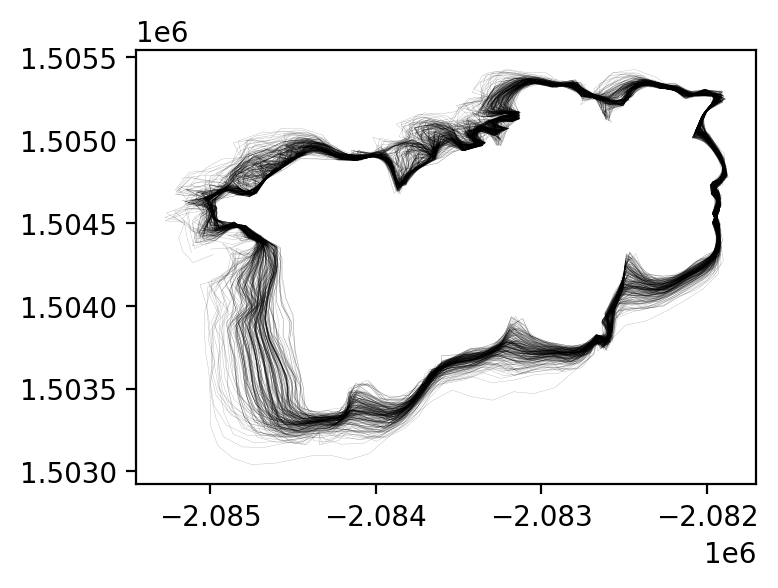

In [25]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.set_aspect('equal')


# for geom in usr_test.db.gdfsimulation['geometry']:
#     if isinstance(geom, MultiPolygon):
#         geom = calculate_max_area_geom(geom)
#     x,y = geom.exterior.coords.xy
#     ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    
    
for i in range(Xt.shape[1]):
    x,y = Xt[:-2:2,i], Xt[1:-2:2,i]
    ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    

# plot_matrix(Xt, ax=ax, show_stdev=True)

# x,y = usr.db.gdfignition.loc[igniteidx_lst[1], 'geometry'].exterior.coords.xy
# ax.plot(x,y, 'k-')

In [30]:
geom = usr.db.gdfignition.loc[igniteidx_lst[1], 'geometry']

uncertainties = np.zeros(nsamples) + 100
interpolate_geom = interpolate_geometries([geom], vertex_count)[0]
aligned_vertices = align_vertices([aligned_geom, interpolate_geom])[1]
st = State(Polygon(aligned_vertices))

aligned_geoms_lst = []
for i in range(nsamples):
    newgeom = sample_geometry(st, uncertainties).buffer(0)
    interpolate_geom = interpolate_geometries([newgeom], vertex_count)[0]
    aligned_vertices = align_vertices([aligned_geom, interpolate_geom])[1]
    aligned_geoms_lst.append(Polygon(aligned_vertices))
    
Y, aligned_geom, vertex_count = create_ensemble_matrix(gpd.GeoDataFrame(geometry=aligned_geoms_lst), nsamples, vertex_count, aligned_geom, observed=True)

'5d2dd067d29d41b6a47893976a37474e'

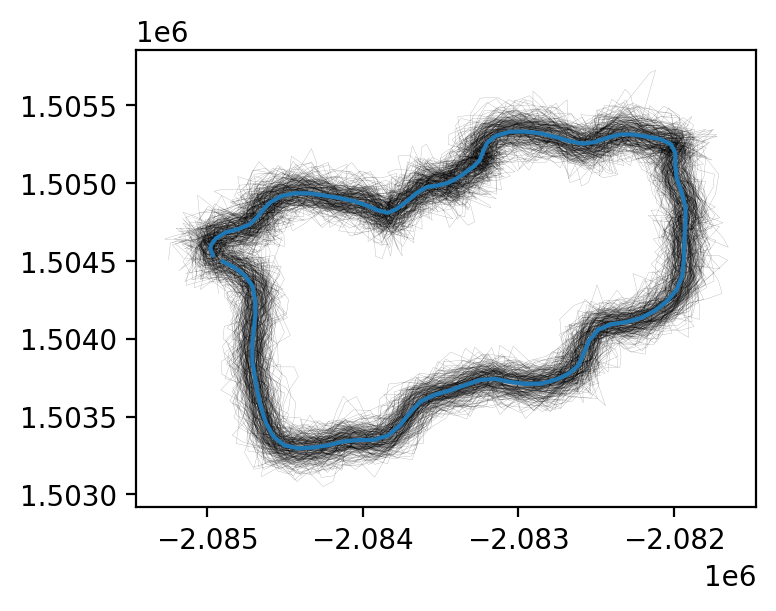

In [31]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.set_aspect('equal')


# for geom in usr_test.db.gdfsimulation['geometry']:
#     if isinstance(geom, MultiPolygon):
#         geom = calculate_max_area_geom(geom)
#     x,y = geom.exterior.coords.xy
#     ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    
    
for i in range(Y.shape[1]):
    x,y = Y[::2,i], Y[1::2,i]
    ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    

plot_matrix(Y, ax=ax, show_stdev=True)

# x,y = usr.db.gdfignition.loc[igniteidx_lst[1], 'geometry'].exterior.coords.xy
# ax.plot(x,y, 'k-')

In [32]:
X = update_EnKF(Xt, Y, aligned_geom)

In [39]:
data = {'calculations': 
        [{'referenceidx': referenceidx,
          'igniteidx': igniteidx,
          'Xt': Xt, 'X': X, 'Y': Y, 'aligned_geom': aligned_geom,
          'wdar': wdar, 'wsar': wsar},
         {},
         {},
         {},
        ],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
        'gdftable': ''
       }

data['calculations'][0]

{'referenceidx': 'b93e051584c54d3183511baf8088fc84',
 'igniteidx': 'f72ef3330247465e88cdb8a27e2a2df6',
 'Xt': array([[-2.08499100e+06, -2.08502600e+06, -2.08523300e+06, ...,
         -2.08505900e+06, -2.08495017e+06, -2.08507250e+06],
        [ 1.50462700e+06,  1.50465700e+06,  1.50453100e+06, ...,
          1.50445700e+06,  1.50453430e+06,  1.50443490e+06],
        [-2.08490378e+06, -2.08492698e+06, -2.08523300e+06, ...,
         -2.08499990e+06, -2.08497500e+06, -2.08500796e+06],
        ...,
        [ 1.50462700e+06,  1.50465700e+06,  1.50445114e+06, ...,
          1.50445700e+06,  1.50447948e+06,  1.50439194e+06],
        [ 1.10000000e+02,  1.02000000e+02,  7.60000000e+01, ...,
          8.70000000e+01,  7.10000000e+01,  7.30000000e+01],
        [ 6.00000000e+00,  1.00000000e+01,  1.60000000e+01, ...,
          1.30000000e+01,  5.00000000e+00,  1.30000000e+01]]),
 'X': array([[-2.08475973e+06, -2.08494732e+06, -2.08562740e+06, ...,
         -2.08469950e+06, -2.08452812e+06, -2.0851

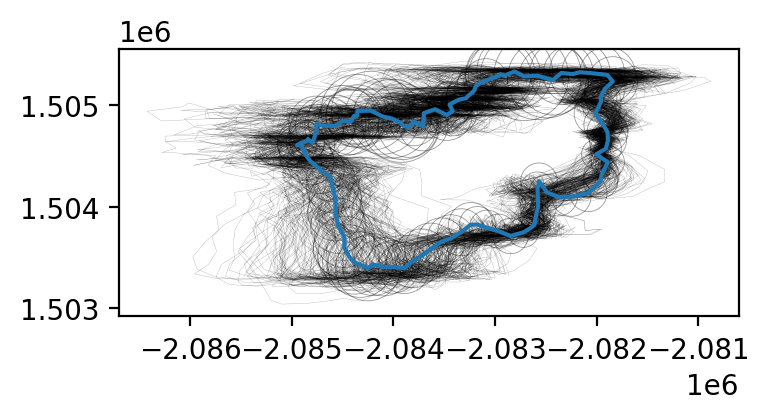

In [33]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.set_aspect('equal')


# for geom in usr_test.db.gdfsimulation['geometry']:
#     if isinstance(geom, MultiPolygon):
#         geom = calculate_max_area_geom(geom)
#     x,y = geom.exterior.coords.xy
#     ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    
    
for i in range(X.shape[1]):
    x,y = X[:-2:2,i], Xt[1:-2:2,i]
    ax.plot(x,y, '-', color=(0,0,0,0.4), lw=0.1)
    

plot_matrix(X[:-2,:], ax=ax, show_stdev=True)

# x,y = usr.db.gdfignition.loc[igniteidx_lst[1], 'geometry'].exterior.coords.xy
# ax.plot(x,y, 'k-')

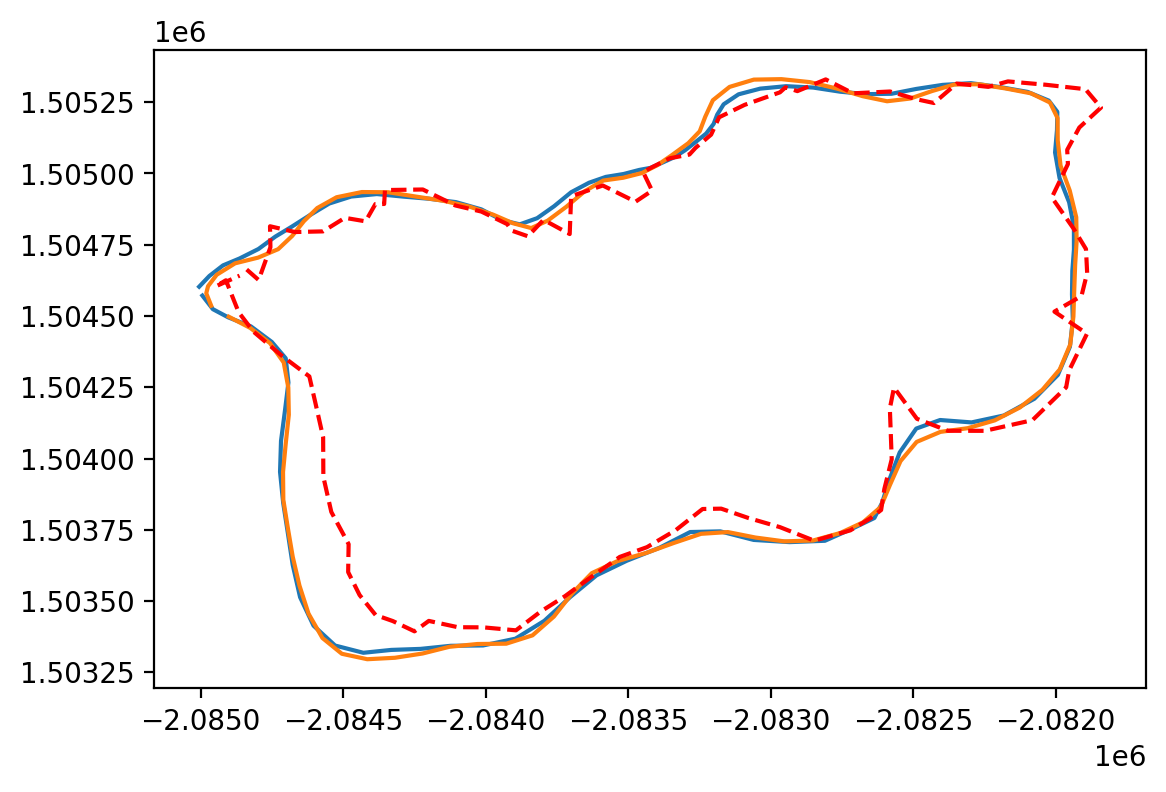

In [34]:
fig, ax = plt.subplots(1,1, dpi=200)
ax.set_aspect('equal')

plot_matrix(Xt[:-2,:], ax)
plot_matrix(Y, ax)
plot_matrix(X[:-2,:], ax, show_stdev=False, color='red', ls='--')


3. Run FARSITE from $I_0$ with the ensemble pairs (**ws, wd**) for dt time. This will create a matrix, $X_t$, of size $(2d+2)\times N$, where $d$ is the number of vertices, and $+2$ is the additional **ws** and **wd** values.
4. From the second observation $I_1$, deviate each vertex randomly from a normal distribution with a radius and std, and obtain M new geometries. Note that obtainin new geometries may require crossing out sections from the geometry to make it valid. Check how this process changes the radius and sigma. This will create a new matrix $Y$ of size $2d \times M$
5. Obtain the errors $E_{X_t}$ and $E_Y$ using the mean $X_t$ column $\bar x_t$ and the observation from $I_0 \rightarrow y$
$$ E_{X_t} = (x_t^0 - \bar x_t , x_t^1 - \bar x_t , \cdots)$$
$$ E_Y = (y^0 - y, y_1 - y, \cdots)$$
6. Calculate the covariance matrices $P_{XY}$ and $P_Y$ of sizes 
$$ P_{XY} = \frac{1}{2d-1}E_XE_Y^T$$
$$ P_Y = \frac{1}{2d-1}E_YE_Y^T$$
7. Calculate the Kalman filter $K = P_{XY}P_Y^{-1}$. Note that while calculating the inverse of the covariance, you can use the psesudoinverse function fin numpy as np.linalg.pinv(...)
8. Calculate the updated state matrix $X'$ using the Kalman filter:
$$X' = X + K(Y - CX),$$
where $C$ is the matrix to remap $2d+2$ dimensions to $2d$, simply generated with an identity matrix + 2 zero columns for each **ws** and **wd**

In [ ]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]
    

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

In [ ]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)


def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?

def create_ensembles(nsamples, current_state, windspeed, winddirection, normalized_scale, filetype, objectid, datetime, description):
                     
    # uncertainty in both x and y for each vertex
    # uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed*normalized_scale)*np.sqrt(current_state.lengths.sum())
    uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=1)

    ignitions = {'igniteidx': [], 
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'datetime': [],
                 'description': [],
                 'geometry': []}

    time_estimator = TimeEstimator(nsamples)
    for sample in range(nsamples):
        print(time_estimator.info_str(sample), end='\r', flush=True)
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}E{sample:04d}')

        geometry = sample_geometry(current_state, uncertainties)
        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
        
    return ignitions


def create_ensemble_matrix(geoms, vertex_count=20, aligned_geom=None):

    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2, nsamples))
    for i, vertices in enumerate(aligned_vertices):
        X[:,i] = vertices.flatten()
        
    return X, aligned_geom, vertex_count


def state_to_ignitions(X_0, objectid_lst, datetime_lst, description_lst, filetype_lst, usr):

    geoms = [Polygon(zip(X_0[::2,i], X_0[1::2,i])).buffer(0) for i in range(X_0.shape[1])]

    ignitions = {'igniteidx': [],
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'geometry': [],
                 'datetime': [],
                 'description': []}

    for sample, geometry in enumerate(geoms):
        filetype = filetype_lst[sample]
        datetime = datetime_lst[sample]
        description = description_lst[sample]
        objectid = objectid_lst[sample]
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}U{sample:04d}')

        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{description}U{sample:04d}_{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
    
    return ignitions

def validate_geoms_matrix(X, aligned_geom):
    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        xx,yy = geom.exterior.xy
        xx = list(xx)
        yy = list(yy)

        geom = np.array(interpolate_perimeter(list(zip(xx, yy)), len(x)))
        geom = align_vertices([aligned_geom, geom])[1]

        X[:,i] = geom.flatten()

    return X

def recalculate_ignition(mainapi):
    runfile = mainapi.runfile_lst[0]
    geom = gpd.read_file(runfile.ignitepath)['geometry'][0]
    state = State(geom)
    uncertainties = calculate_uncertainties_observed(state.vertices, runfile.windspeed, runfile.winddirection, scale=1)
    geom1 = sample_geometry(state, uncertainties).buffer(0)
    gpd.GeoDataFrame({'FID': [0], 'geometry': geom1}, crs='EPSG:5070').to_file(runfile.ignitepath)

### Plotting functions

In [ ]:
def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
       
def update_EnKF(Xt, Y, aligned_geom):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)

    max_Py = abs(Py).max()
    max_Pxy = abs(Pxy).max()
    Py /= max_Py
    Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    # K = np.matmul(Pxy, Py_inv)

    #### Update the state ensemble
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

In [ ]:
class EnKF:
    # Initialize with the first observation
    # Windspeed and direction is given from PyLaski
    def __init__(self, observation: gpd.GeoSeries, windspeed: int, winddirection: int, normalized_scale: float, nsamples: int, usr: futils.User):
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        
        
        self.state_datetime = observation['datetime']
        self.selected_fire = observation['description']
        self.igniteidx = observation.name
        self.current_state = State(state_geom)
        
        
        self.windspeed = windspeed
        self.winddirection = winddirection
        self.normalized_scale = normalized_scale
        self.nsamples = nsamples
        self.usr = usr

        self.ignitions = create_ensembles(self.nsamples, self.current_state, self.windspeed, self.winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition,
                                             gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070)])
        
        # Create ensemble matrix
        self.X_0, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.ignitions['geometry'])
        
    # Updates the state matrix
    # Need to first add the observation into the database (usr.db for now)
    def update(self, compareidx: str, lcpidx: str, barrieridx: str, observation: gpd.GeoSeries, windspeed: int, winddirection: int):
        # Advance the state in Farsite using the windspeed and direction
        inputData_lst = []
        self.mainapi_lst = []
        for igniteidx in self.ignitions['igniteidx']:
            inputData = {'description': self.selected_fire,
                         'igniteidx'  : igniteidx,
                         'compareidx' : compareidx,
                         'lcpidx'     : lcpidx,
                         'barrieridx' : barrieridx,

                         'windspeed': windspeed, 'winddirection': winddirection,
                         'relhumid': 90, 'temperature': 20}

            self.mainapi_lst.append(self.usr.calculatePerimeters(inputData))
            

        # from multiprocessing import Pool

        # numproc = 4
        # pool = Pool(processes=numproc)

        # Run for each FarsiteManual
        for mainapi in self.mainapi_lst:
            # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
            mainapi.run_farsite()
            runfile = mainapi.runfile_lst[0]
            outperimpath = runfile.outpath+'_Perimeters.shp'
            while len(gpd.read_file(outperimpath)) == 0:
                recalculate_ignition(mainapi)
                mainapi.run_farsite()
            
            

        # pool.close()
        # pool.join()
        
        # Filter igniteidx->compareidx simulations only
        df = self.usr.db.gdfsimulation
        filtered_indices = df[df['igniteidx'].isin(self.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index
        
        if (len(filtered_indices) != self.nsamples):
            raise ValueError(f'Expecting {nsamples} simulation outputs, {len(filtered_indices)} found')
        
        self.Xt_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], 
                                                                                 self.vertex_count, self.aligned_geom)
        
        
        
        # Calculate ensemble for the observation
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        # igniteidx = observation.name
        state_datetime = observation['datetime']

        self.observed_state = State(state_geom)

        self.observed_ensemble = create_ensembles(self.nsamples, self.observed_state, windspeed, winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])

        self.Y_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.observed_ensemble['geometry'], self.vertex_count, self.aligned_geom)
        self.Xt_1 = remove_duplicates(self.Xt_1, self.vertex_count)
        self.Y_1 = remove_duplicates(self.Y_1, self.vertex_count)
        
        
        self.X_1 = update_EnKF(self.Xt_1, self.Y_1, self.aligned_geom)
        ##############################
        # Calculate the Kalman Filter
        ###############################

        ####################
        # Recursive updates
        ##################
        
        # Update ignitions
        self.X_0 = self.X_1
        self.ignitions = state_to_ignitions(self.X_0, self.observed_ensemble['objectid'], self.observed_ensemble['datetime'], 
                           self.observed_ensemble['description'], self.observed_ensemble['filetype'], self.usr)
        
        self.current_state = self.observed_state
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition, gpd.GeoDataFrame(self.ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])
        
        # x_1 = X_1.mean(axis=1, keepdims=True)
        
# ## obtain the igniteidx of the ignition
# ## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
# compareidx = '9f82e870591748a9a8a01346d174f2a1'    # t=1 observation
# lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
# barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index        

In [ ]:
def calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model):
    inputData = {'description': 'Maria2019',
                 'igniteidx'  : igniteidx_lst[-1],
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr_model.calculatePerimeters(inputData)
    mainapi.run_farsite()

    gdfsim = usr_model.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
        
    gdfsim_geom = gdfsim_geom.buffer(0)
    
    usr_model.db.gdfignition = pd.concat([usr_model.db.gdfignition, gpd.GeoDataFrame({'filetype': 'Ignition',
                                                                                      'objectid': str(usr_model.db.gdfignition.loc[gdfsim['igniteidx']]['objectid']) + '_farsite',
                                                                                      'filepath': gdfsim['filepath'],
                                                                                      'datetime': gdfsim['datetime'],
                                                                                      'description': gdfsim['description'],
                                                                                      'geometry': gdfsim_geom}, index=[gdfsim.name])
                                         ])
    igniteidx_lst.append(gdfsim.name)
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                     crs='EPSG:5070').to_file(gdfsim['filepath'])

In [ ]:
def test_duplicates(arr):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                print(f'{i} found at pair {rix}, {rjx}')
            i += 1

def remove_duplicates(arr, dnumber):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                # print(f'{i} found at pair {rix}, {rjx}')
                rixlst.append(rix)
                rjxlst.append(rjx)
            i += 1

    arrnew = np.zeros_like(arr)
    arr = np.delete(arr, rixlst, axis=0)

    for j in range(arr.shape[1]):
        vertices = list(zip(arr[::2,j], arr[1::2,j]))
        vertices_interpolated = interpolate_perimeter(vertices, dnumber)

        arrnew[:,j] = np.array(vertices_interpolated).flatten()

    return arrnew

In [ ]:
# Initial params

initial = usr.db.gdfignition.iloc[0]
windspeed = 10   # Calculations are made with windspeed = 10, winddirection = 90
winddirection = 60
nsamples = 1000
normalized_scale = 2

state = EnKF(initial, windspeed, winddirection, normalized_scale, nsamples, usr)
X_0_lst = [state.X_0]

usr_model = futils.User(fp)
# igniteidx_lst = ['f23196b034474744bdca7df94b13e0f7']
igniteidx_lst = [referenceidx_lst[0]]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
ax.set_aspect('equal')

In [ ]:
# np.savetxt('../data/X0.csv', X_0_lst[0], delimiter=',')
# np.savetxt('../data/X1.csv', X_0_lst[1], delimiter=',')
# np.savetxt('../data/Y.csv', state.Y_1, delimiter=',')


In [ ]:
Xt = X_0_lst[0]
Y = np.genfromtxt('../data/Y.csv', delimiter=',')

nsamples = Y.shape[1]

xt = Xt.mean(axis=1, keepdims=True)
y = Y.mean(axis=1, keepdims=True)

Ex = Xt - xt.repeat(nsamples, axis=1)
Ey = Y - y.repeat(nsamples, axis=1)

Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)
Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)

max_Py = abs(Py).max()
max_Pxy = abs(Pxy).max()
Py /= max_Py
Pxy /= max_Pxy

Py_inv = np.linalg.pinv(Py, hermitian=True)

assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
# K = np.matmul(Pxy, Py_inv)

#### Update the state ensemble
X = Xt + np.matmul(K, (Y - Xt))

### TODO ####
# Fix invalid geometries

# X = validate_geoms_matrix(X, aligned_geom)



In [ ]:
X_0_lst[0].shape

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='blue')
# plot_matrix(X, ax=ax, color='black', show_stdev=True, label=r'$X$')
plot_matrix(X_0_lst[1], ax=ax, color='red', show_stdev=True, label=r'$X_t$')
plot_matrix(state.Y_1, ax=ax, color='blue', show_stdev=True, label=r'$Y$')


# ax.legend()
ax.set_aspect('equal')
# plt.imshow(state.Xt_1)

In [ ]:
np.matmul(Ey, Ey.T)

In [ ]:
np.sum(Ey[0,:]**2)

In [ ]:
(np.sum(Ey[0,:]**2) - np.matmul(Ey, Ey.T)[0,0])/np.sum(Ey[0,:]**2)

In [ ]:
def update_EnKF(Xt, Y, aligned_geom):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples-1)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples-1)*np.matmul(Ex, Ey.T)

    # max_Py = abs(Py).max()
    # max_Pxy = abs(Pxy).max()
    # Py /= max_Py
    # Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    # K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    K = np.matmul(Pxy, Py_inv)

    #### Update the state ensemble
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

### Testing EnKF update function

In [ ]:
# %%time

# N = 100
# sigma = 50

# srange = np.arange(10,1001, 10)
# detlst = []

# time_estimator = TimeEstimator(len(srange))
# for i, s in enumerate(srange):
#     print(time_estimator.info_str(i), end='\r', flush=True)
    
#     mat = np.random.randn(N,s)*50
#     P_mat = np.matmul(mat, mat.T)/(nsamples-1)
#     P_mat = P_mat/P_mat.max()
    
#     detlst.append(np.linalg.det(P_mat))
# # P_mat

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(3,2), dpi=200)
# ax.plot(srange, detlst, 'k')
# ax.set_ylim(0, 2e-6)

# ax2 = ax.twinx()

# ax2.semilogy(srange, detlst, 'r')
# ax2.set_ylim(1e-50, 1e-5)
# ax2.set_yticklabels(ax2.get_yticklabels(), color='red')

In [ ]:
# np.matmul(np.linalg.pinv(P_mat, hermitian=True), P_mat)

### Test EnKF is done

In [ ]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# observation = usr.db.gdfignition.iloc[1]
observation = usr.db.gdfignition.loc[referenceidx_lst[1]]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='blue')
plot_matrix(X_0_lst[1], ax=ax, color='black', show_stdev=True, label=r'$X$')
plot_matrix(state.Xt_1, ax=ax, color='red', show_stdev=True, label=r'$X_t$')
plot_matrix(state.Y_1, ax=ax, color='blue', show_stdev=True, label=r'$Y$')


# ax.legend()
ax.set_aspect('equal')
# plt.imshow(state.Xt_1)

In [ ]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# observation = usr.db.gdfignition.iloc[1]
observation = usr.db.gdfignition.loc[referenceidx_lst[2]]
compareidx = observation.name    # t=2 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='blue')
plot_matrix(X_0_lst[2], ax=ax, color='black', show_stdev=True, label=r'$X$')
plot_matrix(state.Xt_1, ax=ax, color='red', show_stdev=True, label=r'$X_t$')
plot_matrix(state.Y_1, ax=ax, color='blue', show_stdev=True, label=r'$Y$')


# ax.legend()
ax.set_aspect('equal')
# plt.imshow(state.Xt_1)

In [ ]:
X_0_lst[0]

### Testing second update

In [ ]:
ignitions = state.usr.db.gdfignition.loc[state.ignitions['igniteidx']]


In [ ]:
fig, ax = plt.subplots(1,1, figsize=

In [ ]:
i = 20

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(gpd.read_file(ignitions.iloc[i]['filepath'])['geometry'][0], ax=ax, label='ignition')
ax.plot(state.X_0[::2, i], state.X_0[1::2, i], 'r--')


ax.set_aspect('equal')

In [ ]:
usr.db.gdfignition.iloc[1]

In [ ]:
observation

In [ ]:
%%time

i = 2
observation = usr.db.gdfignition.loc[referenceidx_lst[i]]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)

In [ ]:
x,y = gpd.read_file(state.mainapi_lst[0].runfile_lst[0].outpath + '_Perimeters.shp')['geometry'][0].coords.xy

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(X_0_lst[1], ax=ax, color='blue')
# plot_matrix(state.X_0[:,1:2], ax=ax)
plot_matrix(state.Y_1, ax=ax, color='green', show_stdev=True)
plot_matrix(state.Xt_1, ax=ax, color='blue', show_stdev=True)
# ax.plot(x,y, 'k--', lw=1)

In [ ]:
X_0_lst.append(state.X_0)


In [ ]:
calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    


In [ ]:
# igniteidx_lst_model = igniteidx_lst.copy()

In [ ]:
i = 2
observation = state.usr.db.gdfignition.iloc[i]
compareidx = observation.name    # t=1 observation

In [ ]:
gpd.read_file(observation['filepath'])['geometry'][0]

In [ ]:
observation['geometry']

In [ ]:
# Advance the state in Farsite using the windspeed and direction
inputData_lst = []
state.mainapi_lst = []

In [ ]:
igniteidx = state.ignitions['igniteidx'][0]
gpd.read_file(state.usr.db.gdfignition.loc[igniteidx, 'filepath'])['geometry'][0]

inputData = {'description': state.selected_fire,
             'igniteidx'  : igniteidx,
             'compareidx' : compareidx,
             'lcpidx'     : lcpidx,
             'barrieridx' : barrieridx,

             'windspeed': windspeed, 'winddirection': winddirection,
             'relhumid': 90, 'temperature': 20}

mainapi = state.usr.calculatePerimeters(inputData)

In [ ]:
mainapi.run_farsite()
runfile = mainapi.runfile_lst[0]
outperimpath = runfile.outpath+'_Perimeters.shp'

In [ ]:
gpd.read_file(outperimpath)['geometry'][0]

In [ ]:
for mainapi in state.mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()
    runfile = mainapi.runfile_lst[0]
    outperimpath = runfile.outpath+'_Perimeters.shp'
    while len(gpd.read_file(outperimpath)) == 0:
        recalculate_ignition(mainapi)
        mainapi.run_farsite()

In [ ]:
# Filter igniteidx->compareidx simulations only
df = state.usr.db.gdfsimulation
filtered_indices = df[df['igniteidx'].isin(state.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index

In [ ]:
create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], state.vertex_count, state.aligned_geom)

In [ ]:
X_0_lst[1]

### Second update test is done

In [ ]:
%%time

calc_range = range(2,10)
time_estimator = TimeEstimator(len(calc_range))
for i in calc_range:
    print(time_estimator.info_str(i))
    observation = usr.db.gdfignition.iloc[i]
    compareidx = observation.name    # t=1 observation

    state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
    X_0_lst.append(state.X_0)

    calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    
igniteidx_lst_model = igniteidx_lst.copy()

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_matrix(X_0_lst[1], ax=ax, color='blue')
# plot_matrix(X_0_lst[2][:,0:1], ax=ax, show_stdev=True)

In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file('/home/jovyan/data/ignitions/Maria2019U0081_f5421b23173641e18b5d780c6d528798.shp')
# gdf['geometry'][0]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(state.Xt_1, ax=ax, show_stdev=True)

# plt.imshow(state.Xt_1)

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

# # plot_matrix(X_0_lst[0], ax)
# # plot_matrix(X_0_lst[1], ax, color='blue')
# plot_matrix(X_0_lst[0], ax, color='black')
# plot_matrix(X_0_lst[1], ax, color='black')
# plot_matrix(X_0_lst[2], ax, color='black')
# plot_matrix(X_0_lst[3], ax, color='black')
# plot_matrix(X_0_lst[4], ax, color='black')
# plot_matrix(X_0_lst[5], ax, color='black')
# plot_matrix(X_0_lst[6], ax, color='black')
# plot_geometry(usr.db.gdfignition.iloc[4]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[6]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[10]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[11]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[12]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[13]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[14]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[15]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[16]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[17]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[18]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[0]['geometry'], ax)

## Compare the predictions from the updated states, observations and using only the first simulation

### 1. Predict with the updated states

In [ ]:
usr_combined = futils.User(fp)
igniteidx_lst = []
compareidx_lst = []
for i, X_0 in enumerate(X_0_lst):
    obrow = usr.db.gdfignition.iloc[i]
    comprow = usr.db.gdfignition.iloc[i+1]
    
    vertices = X_0.mean(axis=1)
    geom = Polygon(zip(vertices[::2],vertices[1::2])).buffer(0)
    
    dt = obrow['datetime']
    desc = obrow['description']
    objid = str(obrow['objectid']) + '_updated'
    ftype = obrow['filetype']
    
    ignitions = state_to_ignitions(X_0.mean(axis=1, keepdims=True), [objid], [dt], [desc], [ftype], usr_combined)
    igniteidx_lst.append(ignitions['igniteidx'][0])
    compareidx_lst.append(comprow.name)
    
    usr_combined.db.gdfignition = pd.concat([usr_combined.db.gdfignition, gpd.GeoDataFrame(ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])

In [ ]:
igniteidx_lst_observed = []
compareidx_lst_observed = []
for i in range(len(igniteidx_lst)):
    igniteidx_lst_observed.append(usr_combined.db.gdfignition.index[i])
    compareidx_lst_observed.append(usr_combined.db.gdfignition.index[i+1])

In [ ]:
# Combine all igniteidx and compareidx into a single

igniteidx_lst_combined = igniteidx_lst + igniteidx_lst_observed
compareidx_lst_combined = compareidx_lst + compareidx_lst_observed

desc_lst_combined = ['Maria2019_updated' for i in range(len(igniteidx_lst))] + ['Maria2019_observed' for i in range(len(igniteidx_lst))]
inputData_lst = []
mainapi_lst = []
for (igniteidx, compareidx, desc) in zip(igniteidx_lst_combined, compareidx_lst_combined, desc_lst_combined):
    inputData = {'description': desc,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : '43b7f5db36994599861eec4849cc68fd',
                 'barrieridx' : 'cb47616cd2dc4ccc8fd523bd3a5064bb',
                 
                 'windspeed': 10, 'winddirection': 60,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr_combined.calculatePerimeters(inputData))
    
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

In [ ]:
# usr_combined.db.gdfignition.to_pickle('/home/jovyan/ignitions.pkl')
# usr_combined.db.gdfsimulation.to_pickle('/home/jovyan/simulations.pkl')

#### Interpolate all the vertices

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$

#### TODO - Question: Can we find a way to not interpolate the vertices
1. Without interpolation, we need to create a matrix that maps the observed vertices to the state vector

## Compare the perimeters

In [ ]:
# gdfignition = pd.read_pickle('/home/jovyan/ignitions.pkl')
# gdfsimulation = pd.read_pickle('/home/jovyan/simulations.pkl')

gdfignition = usr_combined.db.gdfignition
gdfsimulation = usr_combined.db.gdfsimulation

gdfignition_model = usr_model.db.gdfignition
gdfsimulation_model = usr_model.db.gdfsimulation

In [ ]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=2000)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

calculate_error = calculate_area_diff

In [ ]:
geoms_updated = []
geoms_observed = []
geoms_compare = []
geoms_model = []
errors_updated = []
errors_observed = []
errors_model = []
dt = []

for compareidx in compareidx_lst[:-1]:
    gdffiltered = gdfsimulation[gdfsimulation['compareidx'] == compareidx]
    
    geom_updated = gdffiltered[gdffiltered['description'] == 'Maria2019_updated']['geometry'].iloc[0]
    if isinstance(geom_updated, MultiPolygon):
        geom_updated = calculate_max_area_geom(geom_updated)
    geoms_updated.append(geom_updated)
    
    geom_observed = gdffiltered[gdffiltered['description'] == 'Maria2019_observed']['geometry'].iloc[0]
    if isinstance(geom_observed, MultiPolygon):
        geom_observed = calculate_max_area_geom(geom_observed)
    geoms_observed.append(geom_observed)
    
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    if isinstance(geom_compare, MultiPolygon):
        geom_compare = calculate_max_area_geom(geom_compare)
    geoms_compare.append(geom_compare)
    
    gdffiltered_model = gdfsimulation_model[gdfsimulation_model['compareidx'] == compareidx]
    geom_model = gdffiltered_model[gdffiltered_model['description'] == 'Maria2019']['geometry'].iloc[0]
    if isinstance(geom_model, MultiPolygon):
            geom_model = calculate_max_area_geom(geom_model)
    geoms_model.append(geom_model)
    
    dt.append((gdfignition.loc[compareidx, 'datetime'] - gdfignition.iloc[0]['datetime']).total_seconds()/60/60)
    
    errors_updated.append(calculate_error(geom_updated, geom_compare))
    errors_observed.append(calculate_error(geom_observed,  geom_compare))
    errors_model.append(calculate_error(geom_model, geom_compare))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=400)
ax.plot(dt, errors_updated, label='EnKF')
ax.plot(dt, errors_observed, label='Observed')
ax.plot(dt, errors_model, label='Model')

ax.set_xlim(0,6)
ax.set_ylim(0, 2.5e7)

ax.set_xlabel('Hours after first ignition')
ax.set_ylabel('Area difference')

ax.legend()